  school sex  age address famsize Pstatus  Medu  Fedu     Mjob      Fjob  ...  \
0     GP   F   18       U     GT3       A     4     4  at_home   teacher  ...   
1     GP   F   17       U     GT3       T     1     1  at_home     other  ...   
2     GP   F   15       U     LE3       T     1     1  at_home     other  ...   
3     GP   F   15       U     GT3       T     4     2   health  services  ...   
4     GP   F   16       U     GT3       T     3     3    other     other  ...   

  famrel freetime  goout  Dalc  Walc health absences  G1  G2  G3  
0      4        3      4     1     1      3        6   5   6   6  
1      5        3      3     1     1      3        4   5   5   6  
2      4        3      2     2     3      3       10   7   8  10  
3      3        2      2     1     1      5        2  15  14  15  
4      4        3      2     1     2      5        4   6  10  10  

[5 rows x 33 columns]


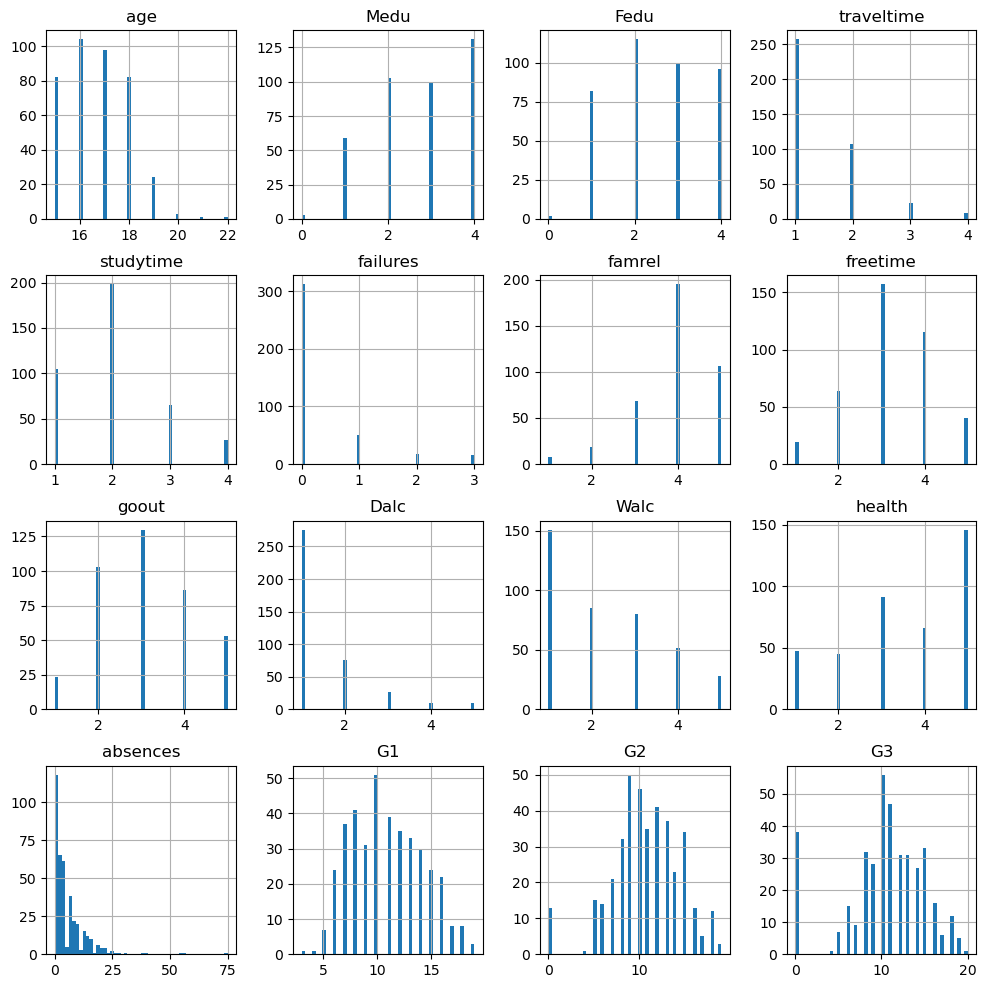

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from 学习 import X_train, y_train

data=pd.read_csv('./student-mat.csv',delimiter=';')
print(data.head())

data.hist(bins=50, figsize=(12, 12))
plt.show()


分析数据特点：
有大量非数字特征，需独热编码。absences有重尾现象，需要对数化

In [5]:
# 划分训练集和测试集
from sklearn.model_selection import train_test_split

X=data.drop(['G1','G2','G3'],axis=1)
y=data['G3']

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)
print(X_train.shape)
print(X.shape)

(316, 30)
(395, 30)


In [6]:
from sklearn.preprocessing import FunctionTransformer,OneHotEncoder,StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

numeric_features = X_train.select_dtypes(include=[np.number]).columns.tolist()
cat_features = X_train.select_dtypes(exclude=[np.number]).columns.tolist()
numeric_features.remove('absences')

preprocessor = ColumnTransformer(
    transformers=[
        ('ab_log',Pipeline(steps=[
            ('imputer',SimpleImputer(strategy='median')),
            ('log',FunctionTransformer(np.log1p))
        ]),['absences']),
        ('num', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='mean')),
            ('scaler', StandardScaler())
        ]), numeric_features),
        ('cat', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('onehot', OneHotEncoder(handle_unknown='ignore'))
        ]), cat_features)
    ],
    remainder='drop',
    verbose_feature_names_out=False
)

In [7]:
# 使用线性回归、多项式回归和决策树回归预测学生期末成绩
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor

full_pipeline_polyreg = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('poly_features', PolynomialFeatures(degree=2)),  # 添加多项式特征
    ('model', LinearRegression())])
full_pipeline_lr=Pipeline(steps=[
    ('preprocessor',preprocessor),
    ('model',LinearRegression())])
full_pipeline_dt=Pipeline(steps=[
    ('preprocessor',preprocessor),
    ('model',DecisionTreeRegressor(max_depth=5,
    min_samples_split=20,
    min_samples_leaf=10,
    max_features=0.8,
    random_state=42))])

In [8]:
from sklearn.metrics import make_scorer,mean_squared_error,r2_score
from sklearn.model_selection import KFold,cross_validate

scoring = {
    'MSE': make_scorer(mean_squared_error, greater_is_better=False),
    'RMSE': make_scorer(lambda y_true, y_pred: mean_squared_error(y_true, y_pred, squared=False),
                        greater_is_better=False),
    'R2': make_scorer(r2_score)}

kfold = KFold(n_splits=5, shuffle=True, random_state=42)

models = {
    'Linear Regression': full_pipeline_lr,
    'Polynomial Regression': full_pipeline_polyreg,
    'Decision Tree': full_pipeline_dt}

results = {}

for model_name, model in models.items():
    cv_results = cross_validate(
        estimator=model,
        X=X_train,
        y=y_train,
        cv=kfold,
        scoring=scoring,
        return_train_score=True,
        n_jobs=-1
    )
    results[model_name] = {
        'test_MSE_mean': -cv_results['test_MSE'].mean(),  # 注意负号（因greater_is_better=False）
        'test_MSE_std': cv_results['test_MSE'].std(),
        'test_RMSE_mean': -cv_results['test_RMSE'].mean(),
        'test_RMSE_std': cv_results['test_RMSE'].std(),
        'test_R2_mean': cv_results['test_R2'].mean(),
        'test_R2_std': cv_results['test_R2'].std()
    }
        # 提取结果
    results[model_name] = {
        'test_MSE': -cv_results['test_MSE'],  # 因为greater_is_better=False
        'test_RMSE': -cv_results['test_RMSE'],
        'test_R2': cv_results['test_R2'],
        'fit_time': cv_results['fit_time']
    }

    # 计算统计量
    stats = {
        'test_MSE_mean': results[model_name]['test_MSE'].mean(),
        'test_MSE_std': results[model_name]['test_MSE'].std(),
        'test_RMSE_mean': results[model_name]['test_RMSE'].mean(),
        'test_RMSE_std': results[model_name]['test_RMSE'].std(),
        'test_R2_mean': results[model_name]['test_R2'].mean(),
        'test_R2_std': results[model_name]['test_R2'].std(),
        'fit_time_mean': results[model_name]['fit_time'].mean()
    }

    print(f"{model_name} 评估结果:")
    print(f"  MSE: {stats['test_MSE_mean']:.4f} ± {stats['test_MSE_std']:.4f}")
    print(f"  RMSE: {stats['test_RMSE_mean']:.4f} ± {stats['test_RMSE_std']:.4f}")
    print(f"  R²: {stats['test_R2_mean']:.4f} ± {stats['test_R2_std']:.4f}")

Linear Regression 评估结果:
  MSE: 20.0008 ± 2.5894
  RMSE: 4.4620 ± 0.3028
  R²: -0.0314 ± 0.2417
Polynomial Regression 评估结果:
  MSE: 34.6135 ± 6.4738
  RMSE: 5.8587 ± 0.5381
  R²: -0.8230 ± 0.5475
Decision Tree 评估结果:
  MSE: 18.4477 ± 2.4292
  RMSE: 4.2856 ± 0.2858
  R²: 0.0608 ± 0.1571
